# **Modelling**
**(Machine Learning)**

The [IBM HR Analytics Employee Attrition & Performance dataset](https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset)  is a fictional dataset created by IBM data scientists to simulate real-world HR data. It contains information about employees’ demographics, job roles, satisfaction levels, performance, and employment history. The dataset has 1,470 rows (employees) and 35 columns, including both categorical and numerical variables, and is used to explore the factors that influence employee attrition and performance. The main feature categories are:

- **Demographics:** Age, Gender, MaritalStatus, Education, EducationField

- **Job Details:** Department, JobRole, JobLevel, JobInvolvement, YearsAtCompany, YearsInCurrentRole, YearsWithCurrManager

- **Compensation:** MonthlyIncome, MonthlyRate, DailyRate, HourlyRate, PercentSalaryHike, StockOptionLevel

- **Satisfaction Metrics:** JobSatisfaction, EnvironmentSatisfaction, RelationshipSatisfaction, WorkLifeBalance

- **Performance & Experience:** PerformanceRating, TotalWorkingYears, NumCompaniesWorked, TrainingTimesLastYear, YearsSinceLastPromotion

- **Other Attributes:** DistanceFromHome, BusinessTravel, OverTime, StandardHours

## Objectives


## Inputs
The dataset was obtained from [Kaggle](https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset)

## Outputs
The cleaned csv file found [here](../data_set/processed/cleaned_employee_attrition.csv)

# ML Workflow

- Load the dataset & check values
- Encode data types if needed
- Create train and test sets
- Set up Grid with different algorithms(minimal params)
- Visualise Results (compare train and test for overfitting etc)
- Select best pipeline
- Tune the best pipeline
- Explanatory Visuals & Conclusions

---

# Change working directory
Change the working directory from its current folder to its parent folder as the notebooks will be stored in a subfolder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\mikee\\Desktop\\employee-turnover-prediction\\jupyter_notebooks'

Make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\mikee\\Desktop\\employee-turnover-prediction'

Changing path directory to the dataset

In [4]:
#path directory
raw_data_dir = os.path.join(current_dir, 'data_set/raw') 

#path directory
processed_data_dir = os.path.join(current_dir, 'data_set/processed') 


---

# Import packages

In [5]:
import numpy as np #import numpy
import pandas as pd #import pandas
import matplotlib.pyplot as plt #import matplotlib
import seaborn as sns #import seaborn
import plotly.express as px # import plotly
sns.set_style('whitegrid') #set style for visuals

---

# Load the raw dataset

In [6]:
#load the dataset
df = pd.read_csv(os.path.join(processed_data_dir, 'cleaned_employee_attrition.csv'))


The raw dataset is loaded using Pandas for ETL process

---

# Understand the dataset structure and content

In [7]:
#display the first 5 rows of the dataset
df.head(3).T

,0,1,2
Age,41,49,37
Attrition,Yes,No,Yes
DistanceFromHome,1,8,2
JobLevel,2,2,1
JobRole,Sales Executive,Research Scientist,Laboratory Technician
JobSatisfaction,4,2,3
MonthlyIncome,5993,5130,2090
NumCompaniesWorked,8,1,6
OverTime,Yes,No,Yes
WorkLifeBalance,1,3,3


In [8]:
#dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      1470 non-null   int64 
 1   Attrition                1470 non-null   object
 2   DistanceFromHome         1470 non-null   int64 
 3   JobLevel                 1470 non-null   int64 
 4   JobRole                  1470 non-null   object
 5   JobSatisfaction          1470 non-null   int64 
 6   MonthlyIncome            1470 non-null   int64 
 7   NumCompaniesWorked       1470 non-null   int64 
 8   OverTime                 1470 non-null   object
 9   WorkLifeBalance          1470 non-null   int64 
 10  YearsSinceLastPromotion  1470 non-null   int64 
 11  YearsWithCurrManager     1470 non-null   int64 
 12  Attrition_encoded        1470 non-null   int64 
 13  OverTime_encoded         1470 non-null   int64 
dtypes: int64(11), object(3)
memory usage: 16

---

## Encode Features

**Features To Encode**

Overtime & Attrition already have encoded versions.

Job Role is also an object with different labels - to preserve label hierarchy will encode separately. Let us check the values for JobRole.

In [9]:
df["JobRole"].value_counts()

JobRole
Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Manager                      102
Sales Representative          83
Research Director             80
Human Resources               52
Name: count, dtype: int64

We have nine different roles across departments. The departments column of original data was dropped as not being of interest to our hypotheses. We can perform basic  label encoding which will map each role to a numeric value or create a hierarchy. The second approach may be better for the simplicity of model and to add meaning to our encoding so we will take this approach. However, the data also includes `JobLevel` so we can use the correlation between this and `JobRole` to order our hierarchy. (if this shows a simple relationship between levels we can probably drop `JobRole` instead).

In [10]:
# 1) Inspect distributions of JobLevel within each JobRole
#import display for better formatting of output
from IPython.display import display
display(
    df.groupby("JobRole")["JobLevel"]
      .agg(['count','min','median','mean','max'])
      .sort_values(['median','mean'], ascending=[True, True])
)

# 2) Build an order based on JobLevel (median, then mean as tiebreaker)
role_stats = (
    df.groupby("JobRole")["JobLevel"]
      .agg(median='median', mean='mean')
      .sort_values(['median','mean'], ascending=[True, True])
      .reset_index()
)
role_stats["role_rank"] = np.arange(1, len(role_stats)+1)  # 1 = most junior, larger = more senior

,count,min,median,mean,max
JobRole,,,,,
Sales Representative,83,1,1.0,1.084337,2
Research Scientist,292,1,1.0,1.202055,3
Laboratory Technician,259,1,1.0,1.239382,3
Human Resources,52,1,1.0,1.480769,3
Sales Executive,326,2,2.0,2.328221,4
Manufacturing Director,145,2,2.0,2.448276,4
Healthcare Representative,131,2,2.0,2.473282,4
Research Director,80,3,4.0,3.975000,5
Manager,102,3,4.0,4.303922,5


The order is reasonably clear, though manager having the highest rank seems like an anomaly (It is described as middle management in the original dataset). 
* Conclusion: Job Level may be a better indicator & less arbritary than JobRole
* We can also check monthly income to find a more definitive hierarchy

In [11]:
##Rank Job Role by MonthlyIncome
role_stats = (
    df.groupby("JobRole")["MonthlyIncome"]
      .agg(median='median', mean='mean')
      .sort_values(['median','mean'], ascending=[True, True])
      .reset_index()
)
role_stats["role_rank"] = np.arange(1, len(role_stats)+1)  # 1 = most junior, larger = more senior
role_stats

,JobRole,median,mean,role_rank
0,Sales Representative,2579.0,2626.000000,1
1,Laboratory Technician,2886.0,3237.169884,2
2,Research Scientist,2887.5,3239.972603,3
3,Human Resources,3093.0,4235.750000,4
4,Sales Executive,6231.0,6924.279141,5
5,Manufacturing Director,6447.0,7295.137931,6
6,Healthcare Representative,6811.0,7528.763359,7
7,Research Director,16510.0,16033.550000,8
8,Manager,17454.5,17181.676471,9


This gives a clearer ranking - we have two measures which seem to effectively rank job roles. Though including it may introduce noise and overcomplicate it may also enrich it and reveal a more interesting picture. (i.e. factors not necessarily related to income or seniority). Fot this reason we will keep it in our model for testing and use LabelEncoding.

**Encode JobRole**


In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df["JobRole_encoded"] = le.fit_transform(df["JobRole"])
df[["JobRole_encoded"]].value_counts().sort_index()

JobRole_encoded
0                  131
1                   52
2                  259
3                  102
4                  145
5                   80
6                  292
7                  326
8                   83
Name: count, dtype: int64

## Create Dataset for training

Next we will create our dataset for training. We can drop columns we have encoded versions of, `Attrition`, `OverTime`.

In [13]:
#create our dataset for training. We can drop columns we have encoded versions of, `Attrition`, `OverTime` 
df_model = df.drop(columns=['Attrition', 'OverTime', 'JobRole'])
df_model.head(3).T


,0,1,2
Age,41,49,37
DistanceFromHome,1,8,2
JobLevel,2,2,1
JobSatisfaction,4,2,3
MonthlyIncome,5993,5130,2090
NumCompaniesWorked,8,1,6
WorkLifeBalance,1,3,3
YearsSinceLastPromotion,0,1,0
YearsWithCurrManager,5,7,0
Attrition_encoded,1,0,1


---

## Create Train & Test sets

Next we split our dataset into training & test sets.

In [14]:
#split our dataset into training & test sets.
from sklearn.model_selection import train_test_split
X = df_model.drop('Attrition_encoded', axis=1)  # Features
y = df_model['Attrition_encoded']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((1176, 11), (294, 11), (1176,), (294,))

**Check Train & Test sets are balanced**

In [15]:
#Check target class distribution in train and test sets
print("Class balance (train):", y_train.value_counts(normalize=True).to_dict())
print("Class balance (test):", y_test.value_counts(normalize=True).to_dict())

Class balance (train): {0: 0.8316326530612245, 1: 0.1683673469387755}
Class balance (test): {0: 0.8673469387755102, 1: 0.1326530612244898}


*Note our test set is slightly inbalanced compared to train - random seed may need changing if inbalance causes problems*

---

## GridSearch with Tree Models

**Create pipeline function**

First we create lists of features depending on type - Ordinal etc., then create a function to create pipelines.

In [16]:
#check numeric columns for unique values
X.nunique(), X.shape

(Age                          43
 DistanceFromHome             29
 JobLevel                      5
 JobSatisfaction               4
 MonthlyIncome              1349
 NumCompaniesWorked           10
 WorkLifeBalance               4
 YearsSinceLastPromotion      16
 YearsWithCurrManager         18
 OverTime_encoded              2
 JobRole_encoded               9
 dtype: int64,
 (1470, 11))

By examining this we can see which are continuous numeric variables and which are ordinal (i.e. have an order/ranking)

In [17]:
### Preprocessing & Feature Selection imports
from sklearn.pipeline import Pipeline
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel

##separate features by type
ordinal_features = ['JobSatisfaction', 'JobLevel','WorkLifeBalance']
numerical_features = ['Age', 'DistanceFrom Home', 'MonthlyIncome', 'NumCompaniesWorked','YearSinceLastPromotion','YearsWithCurrManager']
#Overtime is already encoded as binary, JobRole will be label encoded
ordinal_features, numerical_features

(['JobSatisfaction', 'JobLevel', 'WorkLifeBalance'],
 ['Age',
  'DistanceFrom Home',
  'MonthlyIncome',
  'NumCompaniesWorked',
  'YearSinceLastPromotion',
  'YearsWithCurrManager'])

the next step is to create our pipeline optimisation function.

In [18]:
##Create function to build  model pipelines

# No scaling needed for tree-based models
def PipelineOptimization(model):
    """ Create a pipeline with preprocessing, feature selection, and model steps.
    """
    pipeline_base = Pipeline(steps=[
        # 1) Impute numeric (median is robust to skew)
        ("num_imputer", MeanMedianImputer(imputation_method="median", variables=numerical_features)),

        # 2) Impute categoricals (mode/most frequent)
        ("cat_imputer", CategoricalImputer(imputation_method="frequent", variables=ordinal_features)),

        # 3) Ordinal-encode ordered categories (keeps rank meaning for trees)
        ("ord_encoder", OrdinalEncoder(encoding_method="arbitrary", variables=ordinal_features)),

        # 4) Label-encode JobRole (arbitrary, no rank meaning)
        ("role_encoder", LabelEncoder(encoding_method="arbitrary", variables=["JobRole"])),

        # 5) Feature selection from model (uses model’s importances)
        ("feat_selection", SelectFromModel(model)),

        # 6) Final estimator
        ("model", model),
    ])
    return pipeline_base

**Import Models**

In [19]:
## GridSearch with Tree Models
### Import packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#supress warnings
import warnings
warnings.filterwarnings('ignore')


**Create List of models to test**

In [20]:
# Define dictionary of candidate models
models = {
    "DecisionTree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(
        n_estimators=400, random_state=42, n_jobs=-1, class_weight="balanced_subsample"
    ),
    "ExtraTrees": ExtraTreesClassifier(
        n_estimators=400, random_state=42, n_jobs=-1, class_weight="balanced_subsample"
    ),
    "XGBoost": XGBClassifier(
        n_estimators=400,
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
        use_label_encoder=False
    )
}


**Create Param Grid**
(reduced params for faster runtime)

In [21]:
#No Balance param for XGBoost so create inbalance ratio
from collections import Counter

ctr = Counter(y_train)
pos = ctr[1]  # minority class (leavers)
neg = ctr[0]
scale_pos_weight = neg / pos if pos > 0 else 1.0
scale_pos_weight # This is the class imbalance ratio for use as XGBoost param

4.9393939393939394

In [22]:
##Param grids (AI generated & tweaked - reduced for faster runtime)
param_grids = {
    "DecisionTree": {
        "max_depth": [None, 6, 10],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": [None, "sqrt", "log2"],
        # class_weight is already set on the model
    },

    "RandomForest": {
        "n_estimators": [200, 400],
        "max_depth": [None, 8, 12],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt", "log2", 0.7],
        # class_weight balanced_subsample already set
        "bootstrap": [True],
    },

    "ExtraTrees": {
        "n_estimators": [200, 400],
        "max_depth": [None, 8, 12],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt", "log2", 0.7],
        # class_weight balanced_subsample already set
        "bootstrap": [False],  # ExtraTrees default
    },

    "XGBoost": {
        "n_estimators": [300, 500],
        "learning_rate": [0.05, 0.1],
        "max_depth": [3, 5],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
        "min_child_weight": [1, 3],
        # handle imbalance; test both baseline and weighted
        "scale_pos_weight": [1.0, scale_pos_weight],
        # eval_metric/logloss and use_label_encoder=False are already on the model
    },
}


**Create Training Loop**

Loops over models and param lists (minimised for initial selection).

So as not to repeat code have created notes on each run(below) and changes made (e.g. scorer) - TODO create functions!

In [ ]:
# Create training loop for GridSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
# Define cross-validation strategy and scoring metric
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
scorer = "roc_auc"
#create empty lists to store results
search_results = []
best_models = {}
# Loop over models and param grids
for name, model in models.items():
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring=scorer,
        cv=cv,
        n_jobs=-1,            # parallelize CV
        refit=True,
        verbose=0
    )
    # fit the model
    grid.fit(X_train, y_train)

    # Evaluate on train/test (probabilities → AUC)
    yhat_train = grid.predict_proba(X_train)[:, 1] if hasattr(grid.best_estimator_, "predict_proba") \
                 else grid.decision_function(X_train)
    yhat_test  = grid.predict_proba(X_test)[:, 1]  if hasattr(grid.best_estimator_, "predict_proba") \
                 else grid.decision_function(X_test)

    train_auc = roc_auc_score(y_train, yhat_train)
    test_auc  = roc_auc_score(y_test,  yhat_test)
    # Store results
    search_results.append({
        "Model": name,
        "BestParams": grid.best_params_,
        "CV Best Score (AUC)": grid.best_score_,
        "Train AUC": train_auc,
        "Test AUC": test_auc,
        "Overfit Gap": train_auc - test_auc
    })
    best_models[name] = grid.best_estimator_
# Create results DataFrame
results_df = pd.DataFrame(search_results).sort_values(by="Test AUC", ascending=False)
results_df


,Model,BestParams,CV Best Score (AUC),Train AUC,Test AUC,Overfit Gap
2,ExtraTrees,"{'bootstrap': False, 'max_depth': None, 'max_f...",0.805284,1.000000,0.714228,0.285772
1,RandomForest,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.804546,0.999174,0.704072,0.295101
3,XGBoost,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.799286,0.967698,0.700452,0.267246
0,DecisionTree,"{'max_depth': 6, 'max_features': 'sqrt', 'min_...",0.721523,0.865387,0.587179,0.278208


In [36]:
##Store results for each run - comment out after runs
#Run1
results_df.to_csv('Reports/modelling_results_run1.csv')

**Display Best Models**

In [ ]:
#show best model details (top 1)
best_model_name = results_df.iloc[0]["Model"]
best_model = best_models[best_model_name]
best_model_name, best_model

('ExtraTrees',
 ExtraTreesClassifier(class_weight='balanced_subsample', min_samples_split=5,
                      n_estimators=400, n_jobs=-1, random_state=42))

In [33]:
#Show second best model details
second_best_model_name = results_df.iloc[1]["Model"]
second_best_model = best_models[second_best_model_name]
second_best_model_name, second_best_model

('RandomForest',
 RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=2,
                        n_estimators=200, n_jobs=-1, random_state=42))

**Check Overfitting**

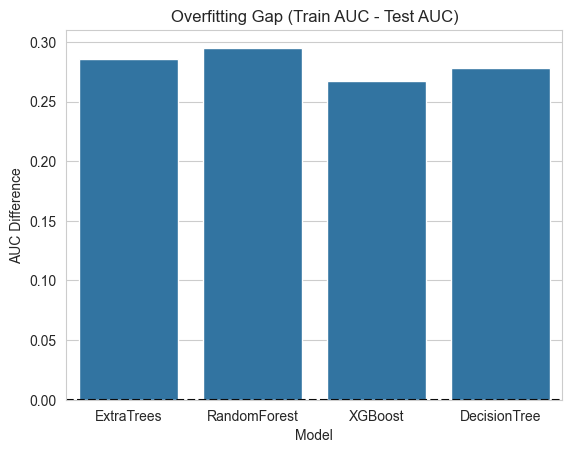

In [28]:
sns.barplot(data=results_df, x="Model", y="Overfit Gap")
plt.title("Overfitting Gap (Train AUC - Test AUC)")
plt.axhline(0, color="black", linestyle="--")
plt.ylabel("AUC Difference")
plt.show()


**Check Accuracy Train vs Test**

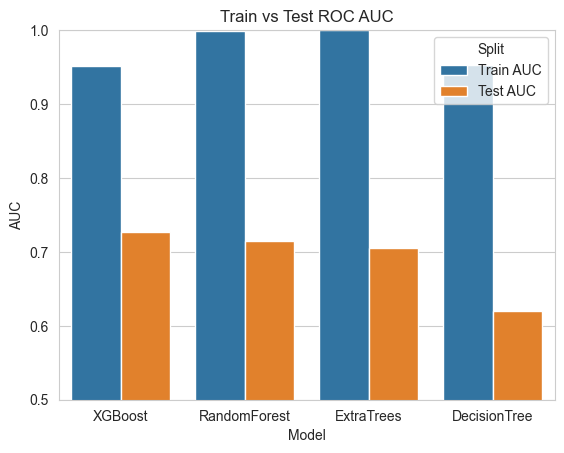

In [25]:
plot_df = results_df.melt(
    id_vars=["Model"],
    value_vars=["Train AUC", "Test AUC"],
    var_name="Split",
    value_name="AUC"
)

sns.barplot(data=plot_df, x="Model", y="AUC", hue="Split")
plt.title("Train vs Test ROC AUC")
plt.ylim(0.5, 1.0)
plt.show()

**Show Confusion Matrix for each model**


=== DecisionTree ===


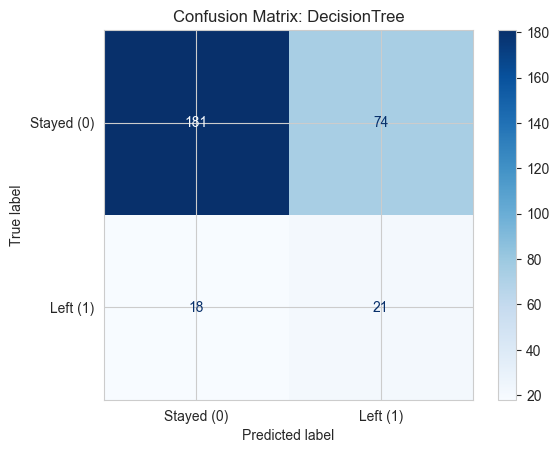

              precision    recall  f1-score   support

      Stayed       0.91      0.71      0.80       255
        Left       0.22      0.54      0.31        39

    accuracy                           0.69       294
   macro avg       0.57      0.62      0.56       294
weighted avg       0.82      0.69      0.73       294


=== RandomForest ===


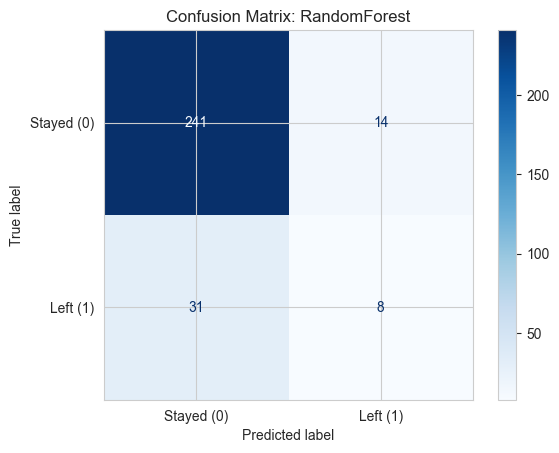

              precision    recall  f1-score   support

      Stayed       0.89      0.95      0.91       255
        Left       0.36      0.21      0.26        39

    accuracy                           0.85       294
   macro avg       0.62      0.58      0.59       294
weighted avg       0.82      0.85      0.83       294


=== ExtraTrees ===


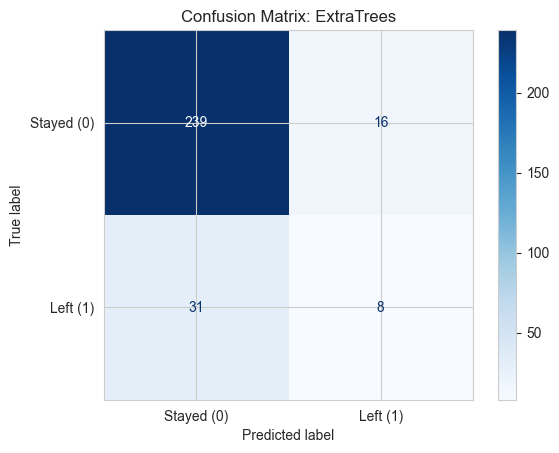

              precision    recall  f1-score   support

      Stayed       0.89      0.94      0.91       255
        Left       0.33      0.21      0.25        39

    accuracy                           0.84       294
   macro avg       0.61      0.57      0.58       294
weighted avg       0.81      0.84      0.82       294


=== XGBoost ===


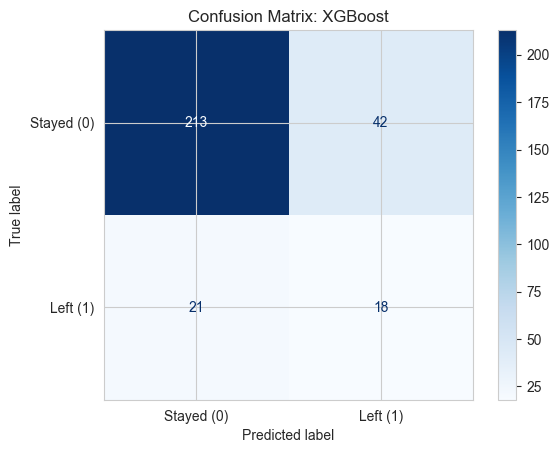

              precision    recall  f1-score   support

      Stayed       0.91      0.84      0.87       255
        Left       0.30      0.46      0.36        39

    accuracy                           0.79       294
   macro avg       0.61      0.65      0.62       294
weighted avg       0.83      0.79      0.80       294



In [ ]:
##Show Confusion Matrix for each model
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)
import matplotlib.pyplot as plt

# You can loop through top models or just one (e.g., the best one)
for name, model in best_models.items():
    print(f"\n=== {name} ===")
    y_pred = model.predict(X_test)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Stayed (0)", "Left (1)"])
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix: {name}")
    plt.show()
    
    # Classification report
    print(classification_report(y_test, y_pred, target_names=["Stayed", "Left"]))


### Notes on Runs

#### Run 1 
Used "roc-auc" as scoring method - results saved to Reports/modelling_results_run1.csv
* Decision Tree & Random Forest selected under best models
* Both had far worse recall though than either XGBoost & Extra Trees 
* XGBoost had lowest value for overfit

In [38]:
class1 = classification_report(y_test, y_pred, target_names=["Stayed", "Left"])
print(class1)

              precision    recall  f1-score   support

      Stayed       0.91      0.84      0.87       255
        Left       0.30      0.46      0.36        39

    accuracy                           0.79       294
   macro avg       0.61      0.65      0.62       294
weighted avg       0.83      0.79      0.80       294



#### Run 2
Used "F1" as scoring method - results saved to Reports/modelling_results_run2.csv
* Decision Tree & Random Forest selected under best models
* Both had far worse recall though than either XGBoost & Extra Trees 
* XGBoost had lowest value for overfit